In [1]:
import pandas as pd
import numpy as np

# Paths – update if needed
train_path = "Train.xlsx"
test_path = "Test.xlsx"

train = pd.read_excel(train_path)
test = pd.read_excel(test_path)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\nTrain head:")
display(train.head())

print("\nTrain info:")
train.info()

print("\nBasic numeric stats (train):")
display(train[["Quantity", "TotalSalesValue"]].describe())


Train shape: (42582, 6)
Test shape: (9135, 5)

Train head:


,ReportID,SalesPersonID,ProductID,Quantity,TotalSalesValue,Suspicious
0,Rep10101,C21116,PR6112,182,1665,indeterminate
1,Rep10102,C21116,PR6112,182,1740,indeterminate
2,Rep10103,C21116,PR6253,101,1040,indeterminate
3,Rep10104,C21116,PR6253,283,4495,No
4,Rep10105,C21116,PR6294,108,1465,indeterminate



Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42582 entries, 0 to 42581
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ReportID         42582 non-null  object
 1   SalesPersonID    42582 non-null  object
 2   ProductID        42582 non-null  object
 3   Quantity         42582 non-null  int64 
 4   TotalSalesValue  42582 non-null  int64 
 5   Suspicious       42582 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB

Basic numeric stats (train):


,Quantity,TotalSalesValue
count,4.258200e+04,4.258200e+04
mean,4.910048e+03,1.620923e+04
std,9.833621e+04,5.997195e+04
min,3.300000e+01,5.980000e+02
25%,1.110000e+02,1.345000e+03
50%,2.060000e+02,2.980000e+03
75%,1.136000e+03,1.076500e+04
max,1.970813e+07,3.953985e+06


In [2]:
# Standardize column names
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

print("Train columns:", train.columns.tolist())
print("Test columns:", test.columns.tolist())

# Check missing values
print("\nMissing values in train:")
print(train.isna().sum())

print("\nMissing values in test:")
print(test.isna().sum())

# Check duplicates
print("\nDuplicate rows in train:", train.duplicated().sum())
print("Duplicate rows in test:", test.duplicated().sum())

# If needed, drop duplicates
# train = train.drop_duplicates()
# test = test.drop_duplicates()

# Ensure numeric types are correct
for col in ["Quantity", "TotalSalesValue"]:
    train[col] = pd.to_numeric(train[col], errors="coerce")
    test[col] = pd.to_numeric(test[col], errors="coerce")

# Quick sanity checks
print("\nQuantity range:", train["Quantity"].min(), "to", train["Quantity"].max())
print("TotalSalesValue range:", train["TotalSalesValue"].min(), "to", train["TotalSalesValue"].max())

# Look at Suspicious values
print("\nSuspicious value counts:")
print(train["Suspicious"].value_counts())


Train columns: ['ReportID', 'SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue', 'Suspicious']
Test columns: ['ReportID', 'SalesPersonID', 'ProductID', 'Quantity', 'TotalSalesValue']

Missing values in train:
ReportID           0
SalesPersonID      0
ProductID          0
Quantity           0
TotalSalesValue    0
Suspicious         0
dtype: int64

Missing values in test:
ReportID           0
SalesPersonID      0
ProductID          0
Quantity           0
TotalSalesValue    0
dtype: int64

Duplicate rows in train: 0
Duplicate rows in test: 0

Quantity range: 33 to 19708130
TotalSalesValue range: 598 to 3953985

Suspicious value counts:
Suspicious
indeterminate    39846
No                2555
Yes                181
Name: count, dtype: int64


In [3]:
# Avoid division by zero
train["UnitPrice"] = train["TotalSalesValue"] / train["Quantity"]
test["UnitPrice"] = test["TotalSalesValue"] / test["Quantity"]

print("\nUnit price stats (train):")
display(train["UnitPrice"].describe())



Unit price stats (train):


count    42582.000000
mean        16.372971
std         79.544612
min          0.005320
25%          6.781874
50%         10.742574
75%         16.385542
max      11297.100000
Name: UnitPrice, dtype: float64

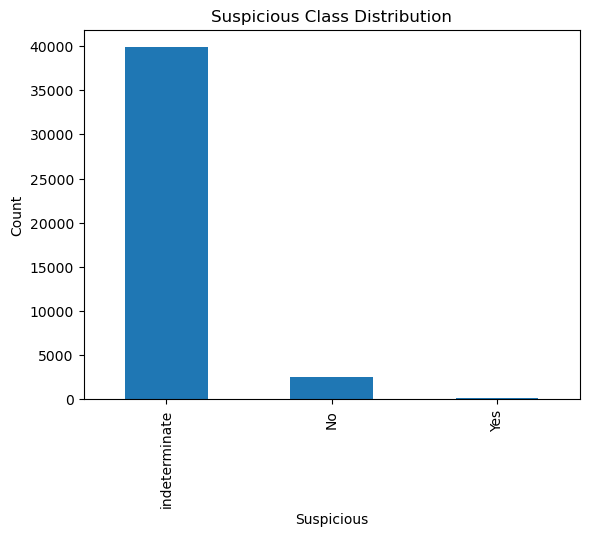


Class distribution (%):
Suspicious
indeterminate    93.57
No                6.00
Yes               0.43
Name: count, dtype: float64


In [4]:
import matplotlib.pyplot as plt #EDA

s_counts = train["Suspicious"].value_counts()

plt.figure()
s_counts.plot(kind="bar")
plt.title("Suspicious Class Distribution")
plt.xlabel("Suspicious")
plt.ylabel("Count")
plt.show()

print("\nClass distribution (%):")
print((s_counts / len(train) * 100).round(2))


In [5]:
# Group by Suspicious flag
suspicious_group_stats = (
    train
    .groupby("Suspicious")[["Quantity", "TotalSalesValue", "UnitPrice"]]
    .agg(["mean", "median", "min", "max"])
)

suspicious_group_stats


Quantity                       TotalSalesValue          \
                        mean  median min       max            mean  median   
Suspicious                                                                   
No              13250.285323   315.0  67   1331792    51863.551468  5550.0   
Yes            137467.707182  1488.0  93  19708130    95837.066298  7680.0   
indeterminate    3773.115118   203.0  33    647835    13561.299603  2955.0   

                               UnitPrice                                     
                min      max        mean     median       min           max  
Suspicious                                                                   
No             1005  1754465   16.193684  10.300000  0.205043    195.747664  
Yes             616  3953985  263.855824   6.603264  0.005320  11297.100000  
indeterminate   598  2265400   15.260279  10.784314  0.029398   1553.806366

In [6]:
# Aggregation per salesperson
salesperson_summary = (
    train
    .groupby("SalesPersonID")
    .agg(
        total_transactions = ("ReportID", "count"),
        total_sales        = ("TotalSalesValue", "sum"),
        total_quantity     = ("Quantity", "sum"),
        suspicious_count   = ("Suspicious", lambda x: (x == "Yes").sum()),
        indeterminate_count= ("Suspicious", lambda x: (x == "indeterminate").sum())
    )
    .reset_index()
)

# Suspicious rate per salesperson
salesperson_summary["suspicious_rate"] = (
    salesperson_summary["suspicious_count"] / salesperson_summary["total_transactions"]
).round(4)

salesperson_summary.sort_values("suspicious_rate", ascending=False).head(10)


,SalesPersonID,total_transactions,total_sales,total_quantity,suspicious_count,indeterminate_count,suspicious_rate
558,C21818,2,11950,166948,1,1,0.5000
709,C21994,8,39235,42583,2,6,0.2500
620,C21893,4,289275,28997,1,2,0.2500
600,C21870,4,4480,2354,1,3,0.2500
601,C21871,4,24105,1791,1,3,0.2500
816,C22127,9,768880,118380,2,7,0.2222
740,C22031,9,386735,114147,2,7,0.2222
748,C22041,10,45290,166324,2,8,0.2000
628,C21901,5,77905,50512,1,4,0.2000
429,C21652,5,443005,71064,1,2,0.2000


In [7]:
product_summary = (
    train
    .groupby("ProductID")
    .agg(
        total_transactions = ("ReportID", "count"),
        total_sales        = ("TotalSalesValue", "sum"),
        total_quantity     = ("Quantity", "sum"),
        suspicious_count   = ("Suspicious", lambda x: (x == "Yes").sum())
    )
    .reset_index()
)

product_summary["suspicious_rate"] = (
    product_summary["suspicious_count"] / product_summary["total_transactions"]
).round(4)

product_summary.sort_values("total_sales", ascending=False).head(10)


,ProductID,total_transactions,total_sales,total_quantity,suspicious_count,suspicious_rate
240,PR6352,649,33368595,764754,2,0.0031
239,PR6351,358,23229050,885567,2,0.0056
226,PR6338,102,19875710,5723814,1,0.0098
535,PR6647,29,19844290,1600564,0,0.0000
241,PR6353,906,16619775,596470,2,0.0022
112,PR6224,222,16536410,3062502,1,0.0045
141,PR6253,2590,14535918,1221349,7,0.0027
3,PR6115,533,12118200,2411744,10,0.0188
363,PR6475,96,12035050,2854327,2,0.0208
566,PR6678,513,11509150,315483,1,0.0019


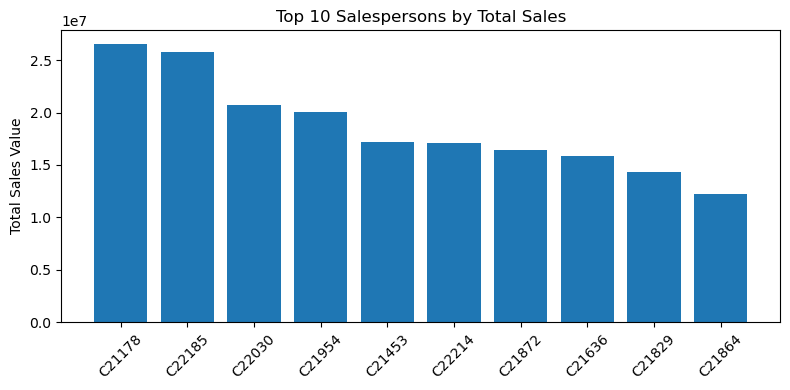

In [8]:
top_salespersons = (
    salesperson_summary
    .sort_values("total_sales", ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
plt.bar(top_salespersons["SalesPersonID"], top_salespersons["total_sales"])
plt.xticks(rotation=45)
plt.title("Top 10 Salespersons by Total Sales")
plt.ylabel("Total Sales Value")
plt.tight_layout()
plt.show()


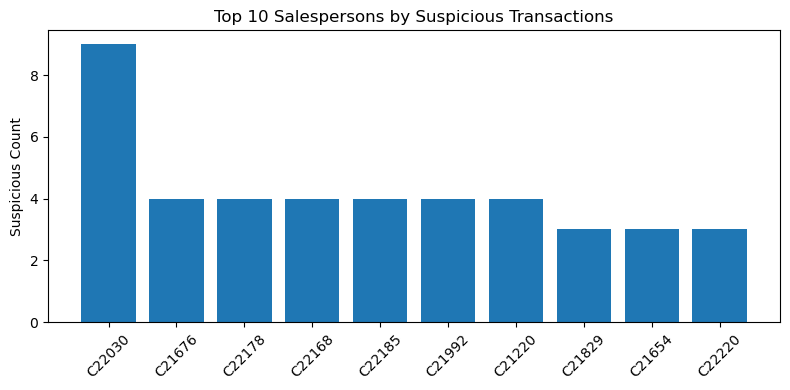

In [9]:
top_suspicious_salespersons = (
    salesperson_summary
    .sort_values("suspicious_count", ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
plt.bar(top_suspicious_salespersons["SalesPersonID"], top_suspicious_salespersons["suspicious_count"])
plt.xticks(rotation=45)
plt.title("Top 10 Salespersons by Suspicious Transactions")
plt.ylabel("Suspicious Count")
plt.tight_layout()
plt.show()


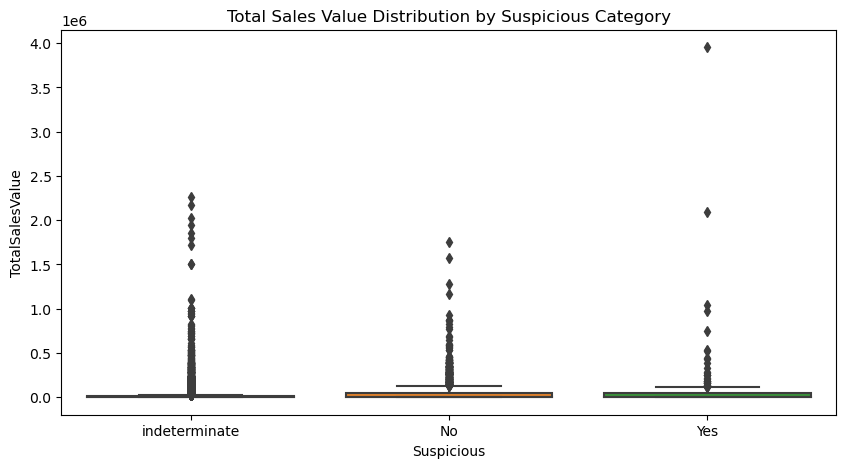

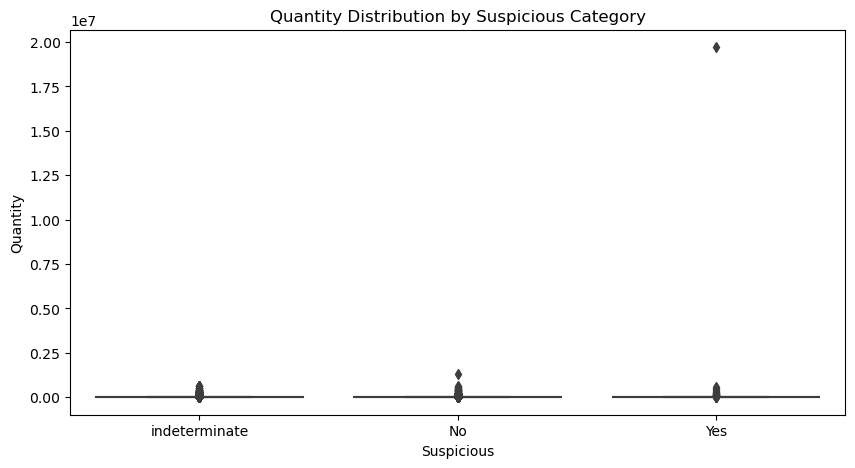

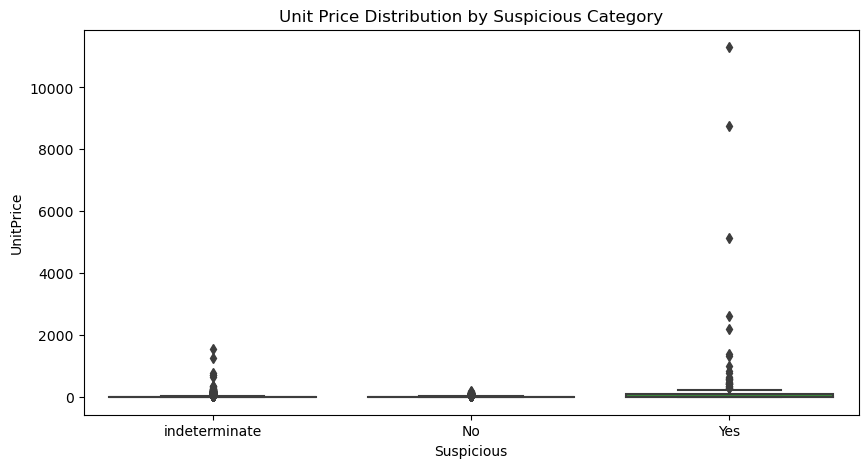

In [10]:
# Compare suspicious categories with numeric behavior
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=train, x="Suspicious", y="TotalSalesValue")
plt.title("Total Sales Value Distribution by Suspicious Category")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=train, x="Suspicious", y="Quantity")
plt.title("Quantity Distribution by Suspicious Category")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=train, x="Suspicious", y="UnitPrice")
plt.title("Unit Price Distribution by Suspicious Category")
plt.show()


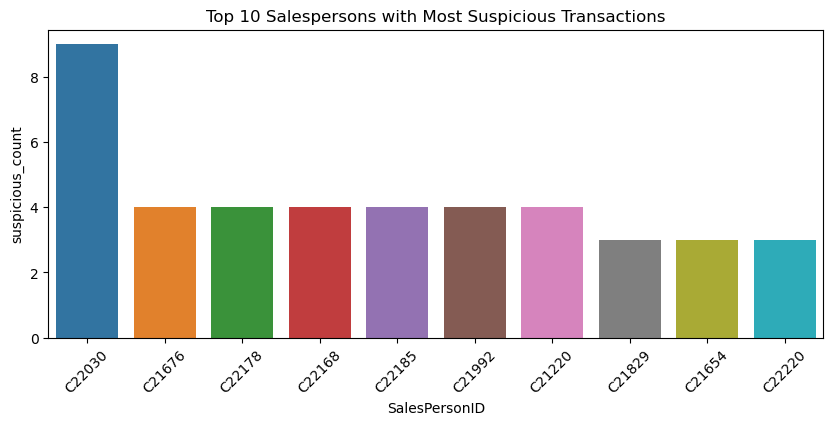

,SalesPersonID,total_transactions,total_sales,total_quantity,suspicious_count,indeterminate_count,suspicious_rate
739,C22030,525,20705860,5525254,9,497,0.0171
448,C21676,22,270100,132221,4,15,0.1818
858,C22178,21,59185,32471,4,17,0.1905
849,C22168,21,427370,555858,4,17,0.1905
863,C22185,397,25799110,1173587,4,357,0.0101
707,C21992,55,2056895,20897797,4,43,0.0727
82,C21220,108,407145,125078,4,91,0.0370
568,C21829,281,14360636,532459,3,243,0.0107
430,C21654,20,600180,282234,3,16,0.1500
891,C22220,347,9402157,3978709,3,327,0.0086


In [11]:
top_suspicious_salespersons = (
    salesperson_summary
    .sort_values("suspicious_count", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,4))
sns.barplot(x="SalesPersonID", y="suspicious_count", data=top_suspicious_salespersons)
plt.title("Top 10 Salespersons with Most Suspicious Transactions")
plt.xticks(rotation=45)
plt.show()

top_suspicious_salespersons


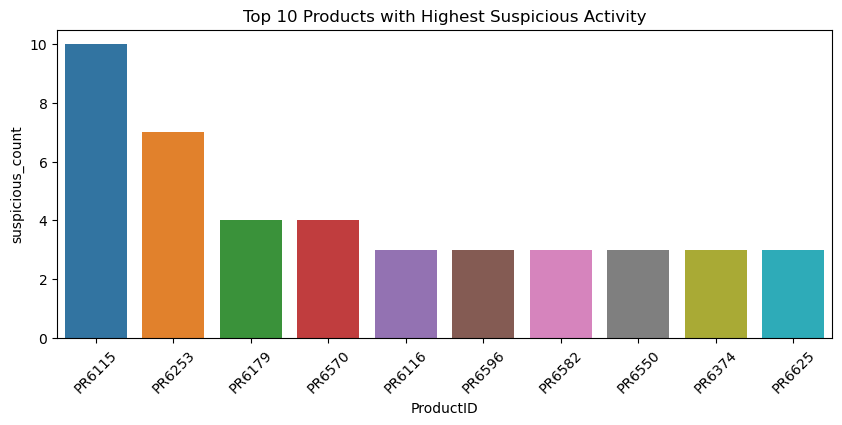

,ProductID,total_transactions,total_sales,total_quantity,suspicious_count,suspicious_rate
3,PR6115,533,12118200,2411744,10,0.0188
141,PR6253,2590,14535918,1221349,7,0.0027
67,PR6179,217,4752770,1341009,4,0.0184
458,PR6570,94,816955,260144,4,0.0426
4,PR6116,315,5104310,524771,3,0.0095
484,PR6596,1194,5149599,558581,3,0.0025
470,PR6582,240,1534515,295024,3,0.0125
438,PR6550,152,2533600,20826472,3,0.0197
262,PR6374,124,1521555,111357,3,0.0242
513,PR6625,154,716870,40896,3,0.0195


In [12]:
top_suspicious_products = (
    product_summary
    .sort_values("suspicious_count", ascending=False)
    .head(10)
)

plt.figure(figsize=(10,4))
sns.barplot(x="ProductID", y="suspicious_count", data=top_suspicious_products)
plt.title("Top 10 Products with Highest Suspicious Activity")
plt.xticks(rotation=45)
plt.show()

top_suspicious_products


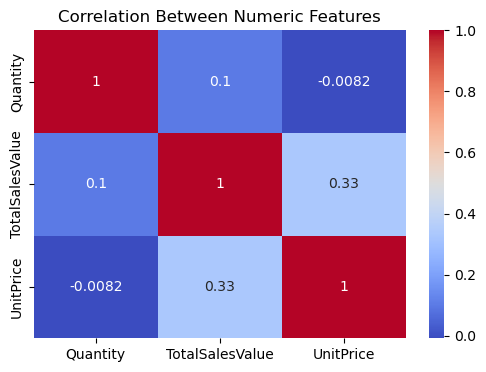

In [13]:
numeric_cols = ["Quantity", "TotalSalesValue", "UnitPrice"]
corr = train[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Numeric Features")
plt.show()


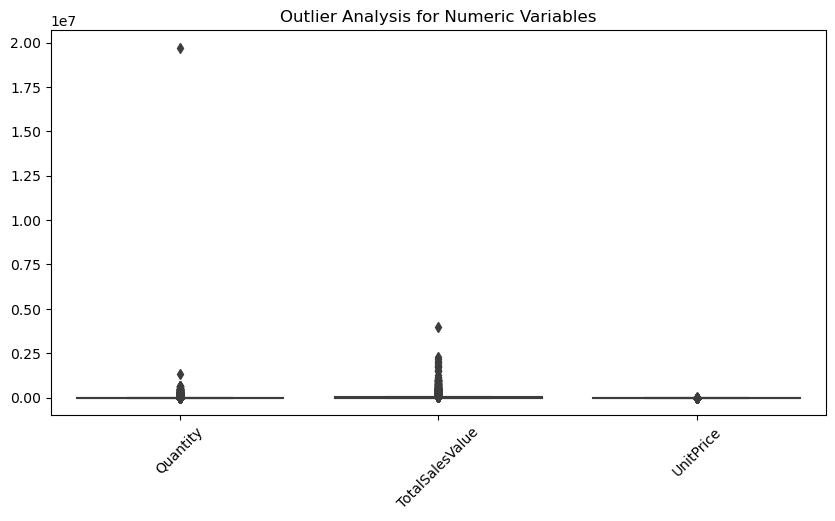

In [14]:
plt.figure(figsize=(10,5))
sns.boxplot(data=train[["Quantity", "TotalSalesValue", "UnitPrice"]])
plt.title("Outlier Analysis for Numeric Variables")
plt.xticks(rotation=45)
plt.show()


In [15]:
insights = {
    "total_transactions": len(train),
    "suspicious_yes": (train["Suspicious"] == "Yes").sum(),
    "suspicious_no": (train["Suspicious"] == "No").sum(),
    "indeterminate": (train["Suspicious"] == "indeterminate").sum(),
    "top_suspicious_salesperson": top_suspicious_salespersons.iloc[0]["SalesPersonID"],
    "top_suspicious_product": top_suspicious_products.iloc[0]["ProductID"]
}

insights


{'total_transactions': 42582,
 'suspicious_yes': 181,
 'suspicious_no': 2555,
 'indeterminate': 39846,
 'top_suspicious_salesperson': 'C22030',
 'top_suspicious_product': 'PR6115'}

In [16]:
train.to_csv("clean_train_for_powerbi.csv", index=False)


In [17]:
salesperson_summary.to_csv("salesperson_summary.csv", index=False)


In [18]:
product_summary.to_csv("product_summary.csv", index=False)
